In [1]:
from pathlib import Path
import os
import time

import requests
import pandas as pd
import numpy as np
import urllib.parse
import pvlib
from pvlib.pvsystem import PVSystem, Array, SingleAxisTrackerMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
import matplotlib.pyplot as plt
import seaborn as sns

# Solar

### Load weather

In [3]:
API_KEY = os.environ.get('NREL_API_KEY')
EMAIL = "adufour@stanford.edu"
BASE_URL = "https://developer.nrel.gov/api/nsrdb/v2/solar/psm3-5min-download.json?"
POINTS = ['421493']
year = 2022
interval = 15

In [4]:
def get_response_json_and_handle_errors(response: requests.Response) -> dict:
    """Takes the given response and handles any errors, along with providing
    the resulting json

    Parameters
    ----------
    response : requests.Response
        The response object

    Returns
    -------
    dict
        The resulting json
    """
    if response.status_code != 200:
        print(f"An error has occurred with the server or the request. The request response code/status: {response.status_code} {response.reason}")
        print(f"The response body: {response.text}")
        exit(1)

    try:
        response_json = response.json()
    except:
        print(f"The response couldn't be parsed as JSON, likely an issue with the server, here is the text: {response.text}")
        exit(1)

    if len(response_json['errors']) > 0:
        errors = '\n'.join(response_json['errors'])
        print(f"The request errored out, here are the errors: {errors}")
        exit(1)
    return response_json

In [5]:
input_data = {
    'attributes': 'dhi,dni,wind_speed,air_temperature,ghi,solar_zenith_angle,total_precipitable_water',
    'interval': str(interval),
    'to_utc': 'false',
    'include_leap_day': 'true',
    
    'api_key': API_KEY,
    'email': EMAIL,
}

for name in [str(year)]:
    print(f"Processing name: {name}")
    for id, location_ids in enumerate(POINTS):
        input_data['names'] = [name]
        input_data['location_ids'] = location_ids
        print(f'Making request for point group {id + 1} of {len(POINTS)}...')

        if '.csv' in BASE_URL:
            url = BASE_URL + urllib.parse.urlencode(data, True)
            # Note: CSV format is only supported for single point requests
            # Suggest that you might append to a larger data frame
            data = pd.read_csv(url)
            print(f'Response data (you should replace this print statement with your processing): {data}')
            # You can use the following code to write it to a file
            # data.to_csv('SingleBigDataPoint.csv')
        else:
            headers = {
                'x-api-key': API_KEY
            }
            data = get_response_json_and_handle_errors(requests.post(BASE_URL, input_data, headers=headers))
            download_url = data['outputs']['downloadUrl']
            # You can do with what you will the download url
            print(data['outputs']['message'])
            print(f"Data can be downloaded from this url when ready: {download_url}")

            # Delay for 1 second to prevent rate limiting
            time.sleep(1)
        print(f'Processed')

Processing name: 2022
Making request for point group 1 of 1...
File generation in progress. An email will be sent to adufour@stanford.edu when the download is ready.
Data can be downloaded from this url when ready: https://mapfiles.nrel.gov/data/solar/ad367a79468d1faad2ee949da7dd92ad.zip
Processed


### Build system

In [242]:
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']
cec_modules = pvlib.pvsystem.retrieve_sam('cecmod')
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
cec_module = cec_modules['Canadian_Solar_Inc__CS6X_330P']
cec_inverter = cec_inverters['Canadian_Solar_Inc___CSI_3000TL_CT__240V_']
mps = 10

In [184]:
print("min series", cec_inverter.Mppt_low / (cec_module.V_mp_ref + 45*cec_module.beta_oc))

min series 3.2364250578268243


In [185]:
print("max series", cec_inverter.Mppt_high / (cec_module.V_mp_ref - 10 *cec_module.beta_oc))

max series 12.176045935299083


In [222]:
mount = SingleAxisTrackerMount()
array = Array(mount,
              module_parameters=cec_module,
              modules_per_string=mps,
              temperature_model_parameters=temperature_model_parameters)
system = PVSystem(array,
                  inverter_parameters=cec_inverter)

In [223]:
location = Location(latitude=37.7552, longitude=-120.8445)

In [224]:
mc = ModelChain(system, location, aoi_model='physical')

### Process weather

In [225]:
mc.run_model(weather)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: sandia_inverter
  aoi_model: physical_aoi_loss
  spectral_model: first_solar_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

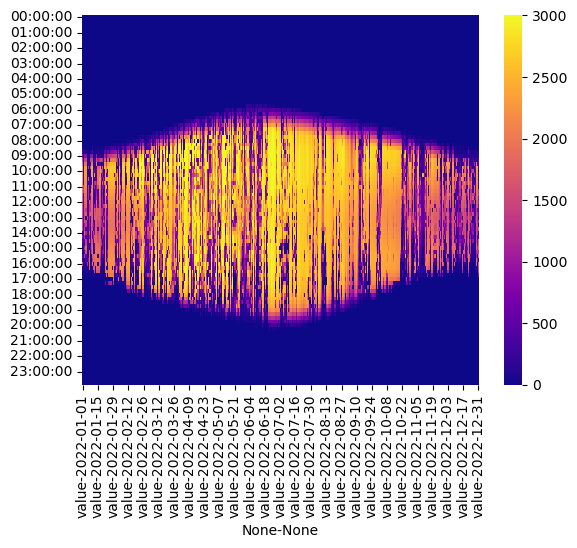

In [226]:
res =  mc.results.ac
df = pd.DataFrame({'value': res})
pivot = pd.pivot_table(df, index=df.index.time, columns=df.index.date)
sns.heatmap(pivot, cmap='plasma');

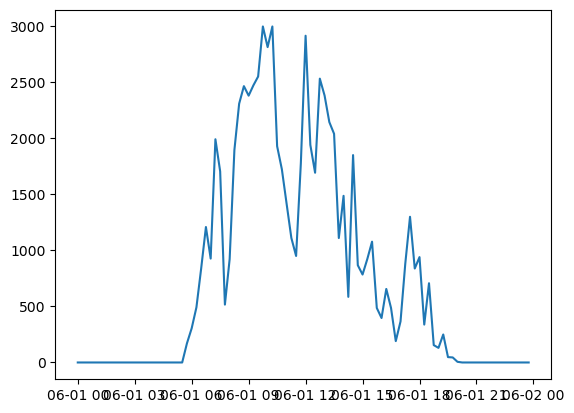

In [227]:
plt.plot(mc.results.ac['2022-06-01']);

In [228]:
lf = mc.results.ac.sum() / (mps*cec_module.STC*8760*4)
print(f"load factor: {np.round(100*lf,1)} %")

load factor: 23.1 %


In [237]:
pv_load = mc.results.ac / (mps*cec_module.STC) # MW per MWdc
pv_load = pv_load.clip(0)
pv_load.to_csv("pv_utilityscale_load.csv")